<a href="https://colab.research.google.com/github/yanxiaoqi932/Machine-Learning/blob/main/Hessian%20Matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 2-2 Hessian Matrix**

* Slides: https://speech.ee.ntu.edu.tw/~hylee/ml/ml2021-course-data/hw/HW02/HW02.pdf
* Video (Chinese): https://youtu.be/PdjXnQbu2zo
* Video (English): https://youtu.be/ESRr-VCykBs


## Hessian Matrix
Imagine we are training a neural network and we are trying to find out whether the model is at **local minima like, saddle point, or none of the above**. We can make our decision by calculating the Hessian matrix.

In practice, it is really hard to find a point where the gradient equals zero or all of the eigenvalues in Hessian matrix are greater than zero. In this homework, we make the following two assumptions:
1. View gradient norm less than 1e-3 as **gradient equals to zero**.
2. If minimum ratio is greater than 0.5 and gradient norm is less than 1e-3, then we assume that the model is at “local minima like”.

> Minimum ratio is defined as the proportion of positive eigenvalues.

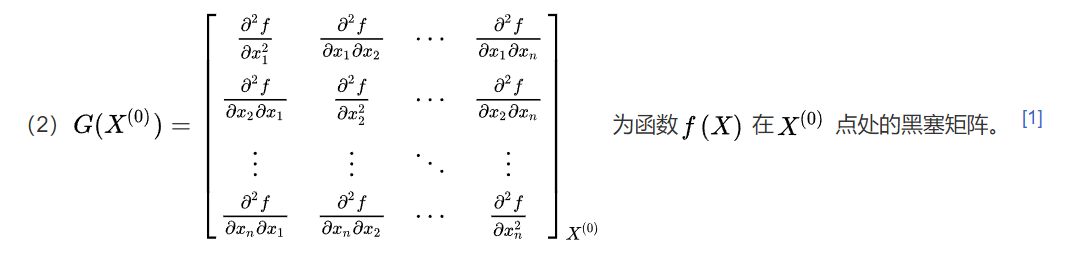

## IMPORTANT NOTICE
In this homework, students with different student IDs will get different answers. Make sure to fill in your `student_id` in the following block correctly. Otherwise, your code may not run correctly and you will get a wrong answer.

In [13]:
student_id = 'your_student_id' # fill with your student ID

#assert student_id != 'your_student_id', 'Please fill in your student_id before you start.'

## Calculate Hessian Matrix
The computation of Hessian is done by TA, you don't need to and shouldn't change the following code. The only thing you need to do is to run the following blocks and determine whether the model is at `local minima like`, `saddle point`, or `none of the above` according to the value of `gradient norm` and `minimum ratio`.

### Install Package to Compute Hessian.

The autograd-lib library is used to compute Hessian matrix. You can check the full document here https://github.com/cybertronai/autograd-lib.

In [2]:
!pip install autograd-lib

     |████████████████████████████████| 925 kB 5.7 MB/s 
     |████████████████████████████████| 829 kB 43.6 MB/s 
     |████████████████████████████████| 596 kB 51.8 MB/s 
     |████████████████████████████████| 329 kB 58.6 MB/s 
     |████████████████████████████████| 125 kB 71.5 MB/s 
     |████████████████████████████████| 1.3 MB 27.6 MB/s 
     |████████████████████████████████| 271 kB 60.7 MB/s 
     |████████████████████████████████| 160 kB 47.8 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=43151809c3f06fdae575115703681d92d656b33820476e76a420c88c55679914
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0

### Import Libraries


In [3]:
import numpy as np
from math import pi
from collections import defaultdict
from autograd_lib import autograd_lib

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings("ignore")

### Define NN Model
The NN model here is used to fit a single variable math function.
$$f(x) = \frac{\sin(5\pi x)}{5\pi x}.$$

In [4]:
class MathRegressor(nn.Module):
    def __init__(self, num_hidden=128):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(1, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, 1)
        )

    def forward(self, x):
        x = self.regressor(x)
        return x

### Get Pretrained Checkpoints
The pretrained checkpoints is done by TA. Each student will get a different checkpoint.

In [5]:
!gdown --id 1ym6G7KKNkbsqSnMmnxdQKHO1JBoF0LPR

Downloading...
From: https://drive.google.com/uc?id=1ym6G7KKNkbsqSnMmnxdQKHO1JBoF0LPR
To: /content/data.pth
100% 34.5k/34.5k [00:00<00:00, 13.1MB/s]


### Load Pretrained Checkpoints and Training Data

In [6]:
# find the key from student_id
import re

key = student_id[-1]
if re.match('[0-9]', key) is not None:
    key = int(key)
else:
    key = ord(key) % 10

In [7]:
# load checkpoint and data corresponding to the key
model = MathRegressor()
autograd_lib.register(model)

data = torch.load('data.pth')[key]
model.load_state_dict(data['model'])
train, target = data['data']

### Function to compute gradient norm

In [24]:
# function to compute gradient norm
def compute_gradient_norm(model, criterion, train, target):
    model.train()
    model.zero_grad()
    output = model(train)
    loss = criterion(output, target)
    loss.backward()

    grads = []
    for p in model.regressor.children():    #children用于遍历model当前层,获取参数
        print('model.regressor.children():{}'.format(p))
        # model.regressor.children()的输出
        # model.regressor.children():Linear(in_features=1, out_features=128, bias=True)
        # model.regressor.children():ReLU()
        # model.regressor.children():Linear(in_features=128, out_features=1, bias=True)
        if isinstance(p, nn.Linear):    #isinstance()函数来判断一个对象是否是一个已知的类型，类似type()
            param_norm = p.weight.grad.norm(2).item()
            print('p.weight.grad.norm(2).item():{}'.format(param_norm))
            grads.append(param_norm)

    grad_mean = np.mean(grads) # compute mean of gradient norms

    return grad_mean

### Function to compute minimum ratio

In [25]:
# source code from the official document https://github.com/cybertronai/autograd-lib
'''计算最小的梯度范数'''
# helper function to save activations
def save_activations(layer, A, _):
    '''
    A is the input of the layer, we use batch size of 6 here
    layer 1: A has size of (6, 1)
    layer 2: A has size of (6, 128)
    '''
    activations[layer] = A

# helper function to compute Hessian matrix
def compute_hess(layer, _, B):
    '''
    B is the backprop value of the layer
    layer 1: B has size of (6, 128)
    layer 2: B ahs size of (6, 1)
    '''
    A = activations[layer]
    BA = torch.einsum('nl,ni->nli', B, A) # do batch-wise outer product
    # 解释一下torch的einsum函数，即爱因斯坦求和简计法，具体可以参考文章：https://blog.csdn.net/a2806005024/article/details/96462827   
    # 'ik, kj -> ij'语义解释如下：
    # 输入a_tensor: 2维数组，下标为ik,
    # 输入b_tensor: 2维数组，下标为kj,
    # 输出output：2维数组，下标为ij。
    # 隐含语义：输入a,b下标中相同的k，是求和的下标，对应上面的例子2的公式
    # 例：output = torch.einsum('ik, kj -> ij', a_tensor, b_tensor)，也就是求两个矩阵的积矩阵

    # full Hessian
    hess[layer] += torch.einsum('nli,nkj->likj', BA, BA) # do batch-wise outer product, then sum over the batch

In [1]:
# function to compute the minimum ratio
'''利用上述的save_activations函数和compute_hess函数，来计算heesian矩阵的最小比率'''
def compute_minimum_ratio(model, criterion, train, target):
    model.zero_grad()
    # compute Hessian matrix
    # save the gradient of each layer
    with autograd_lib.module_hook(save_activations):    #运行save_activations函数
        output = model(train)
        loss = criterion(output, target)

    # compute Hessian according to the gradient value stored in the previous step
    with autograd_lib.module_hook(compute_hess):    #运行compute_hess函数，得到hess矩阵
        autograd_lib.backward_hessian(output, loss='LeastSquares')

    layer_hess = list(hess.values())
    minimum_ratio = []

    # compute eigenvalues of the Hessian matrix
    for h in layer_hess:
        size = h.shape[0] * h.shape[1]
        h = h.reshape(size, size)
        h_eig = torch.symeig(h).eigenvalues # torch.symeig() returns eigenvalues and eigenvectors of a real symmetric matrix
        num_greater = torch.sum(h_eig > 0).item()
        minimum_ratio.append(num_greater / len(h_eig))

    ratio_mean = np.mean(minimum_ratio) # compute mean of minimum ratio

    return ratio_mean

### Mathematical Derivation

Method used here: https://en.wikipedia.org/wiki/Gauss–Newton_algorithm

> **Notations** \\
> $\mathbf{A}$: the input of the layer. \\
> $\mathbf{B}$: the backprop value. \\
> $\mathbf{Z}$: the output of the layer. \\
> $L$: the total loss, mean squared error was used here, $L=e^2$. \\
> $w$: the weight value.

Assume that the input dimension of the layer is $n$, and the output dimension of the layer is $m$.

The derivative of the loss is

\begin{align*}
    \left(\frac{\partial L}{\partial w}\right)_{nm} &= \mathbf{A}_m \mathbf{B}_n,
\end{align*}

which can be written as

\begin{align*}
    \frac{\partial L}{\partial w} &= \mathbf{B} \times \mathbf{A}.
\end{align*}

The Hessian can be derived as

\begin{align*}
    \mathbf{H}_{ij}&=\frac{\partial^2 L}{\partial w_i \partial w_j} \\
    &= \frac{\partial}{\partial w_i}\left(\frac{\partial L}{\partial w_j}\right) \\
    &= \frac{\partial}{\partial w_i}\left(\frac{2e\partial e}{\partial w_j}\right) \\
    &= 2\frac{\partial e}{\partial w_i}\frac{\partial e}{\partial w_j}+2e\frac{\partial^2 e}{\partial w_j \partial w_i}.
\end{align*}

We neglect the second-order derivative term because the term is relatively small ($e$ is small)

\begin{align*}
    \mathbf{H}_{ij}
    &\propto \frac{\partial e}{\partial w_i}\frac{\partial e}{\partial w_j},
\end{align*}

and as the error $e$ is a constant

\begin{align*}
    \mathbf{H}_{ij}
    &\propto \frac{\partial L}{\partial w_i}\frac{\partial L}{\partial w_j},
\end{align*}

then the full Hessian becomes

\begin{align*}
    \mathbf{H} &\propto (\mathbf{B}\times\mathbf{A})\times(\mathbf{B}\times\mathbf{A}).
\end{align*}


In [27]:
# the main function to compute gradient norm and minimum ratio
def main(model, train, target):
    criterion = nn.MSELoss()

    gradient_norm = compute_gradient_norm(model, criterion, train, target)
    minimum_ratio = compute_minimum_ratio(model, criterion, train, target)

    print('gradient norm: {}, minimum ratio: {}'.format(gradient_norm, minimum_ratio))

After running this block, you will get the value of `gradient norm` and `minimum ratio`. Determine whether the model is at `local minima like`, `saddle point`, or `none of the above`, and then submit your choice to NTU COOL.

In [28]:
if __name__ == '__main__':
    # fix random seed
    torch.manual_seed(0)

    # reset compute dictionaries
    activations = defaultdict(int)
    hess = defaultdict(float)

    # compute Hessian
    main(model, train, target)

model.regressor.children():Linear(in_features=1, out_features=128, bias=True)
p.weight.grad.norm(2).item():0.0005872819456271827
model.regressor.children():ReLU()
model.regressor.children():Linear(in_features=128, out_features=1, bias=True)
p.weight.grad.norm(2).item():0.001302635297179222
gradient norm: 0.0009449586214032024, minimum ratio: 0.4921875
